# TNS Fisher forecasts on GC multipoles at z=0.5

In [1]:
# Name this run - this will determine the name for the file into which the covariance matrix will be saved
runname = 'el024_mcmcfids'

## Set up the notebook

In [2]:
# Import the science packages/libraries
from __future__ import division
from __future__ import print_function
import numpy as np
import scipy, scipy.interpolate, scipy.misc, scipy.integrate, scipy.stats
import elgc
import getdist, getdist.plots, IPython
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

import os.path as op
import matplotlib.pyplot as plt

In [3]:
# Set plotting and printing

%matplotlib inline

font = {'size'   : 16, 'family':'STIXGeneral'}
axislabelfontsize='x-large'
plt.rc('font', **font)
plt.rcParams['text.usetex'] = True

np.set_printoptions(precision=3,linewidth=200,suppress=False)

from matplotlib.patches import Ellipse

In [4]:
# Main question for the Fisher matrix calculation: which parameters are we varying?
# Note that this list determines the order in the output FM as well

varypars = ['f','b','b2','N','sv'] 

print(varypars)

['f', 'b', 'b2', 'N', 'sv']


## Set up the fiducial model for the Fisher matrix calculation

In [5]:
#Fiducial (GR-COLA) cosmology 

zbin = 0.5

c=3e5
hubble = 0.697
H00 = 100*hubble
Tcmb = 2.726
ns = 0.971
om0 = 0.281
omb = 0.046
sigma80_fid = 0.844 #this is sigma8 at z=0


#Mean MCMC values for TNS at z=0.5 (to compare with the MCMC)
sv_fid = 9.544  
b_fid = 1.498 
b2_fid = 0.4233 
N_fid = -468.4 
fg_fid = 0.777

#kmax at z=0.5 for multipoles: 0,2,4 
kmax = [0.227, 0.227, 0.129]

In [6]:
#k values are the same in all files ### Paths to input files
PATHTOINPUTFILES = op.abspath('./inputs/')

# Function to read the output files from MG-COPTER
def read_copter(path,suffix=''):
    
    #naming files (following the Mathematica notebook)
    psfile = ('eft_ps_components_nw'+suffix+'.dat')
    abcfile = ('eft_abc_components'+suffix+'.dat')
    biasfile = ('eft_bias_components'+suffix+'.dat')
    
    # set the names of the columns (following the Mathematica notebook)
    pscolnames = 'k', 'pl', 'pdd', 'pdt', 'ptt', 'P5' #P5 not used 
    abccolnames = 'k', 'bu2f2', 'bu2f3', 'bu4f2', 'bu4f3', 'bu6f3', 'b2u2f1', 'b2u2f2', 'b2u2f3',\
    'b2u2f4', 'b2u4f2', 'b2u4f3', 'b2u4f4', 'b2u6f3', 'b2u6f4', 'b2u8f4', 'u2f4', 'u4f3', 'u4f4',\
    'u6f3', 'u6f4', 'u8f4' 
    biascolnames = 'k', 'ddb0b2', 'ddb02', 'ddb0', 'ddb22', 'ddb2', 'ddnone', 'dtb2', 'dtb0', 'dtnone'
    
    return np.genfromtxt(op.join(path,psfile), names=pscolnames),\
           np.genfromtxt(op.join(path,abcfile), names=abccolnames),\
           np.genfromtxt(op.join(path,biasfile), names=biascolnames)

# use numpy to read the whole files, the options will make the
# resulting object act a bit like a dictionary (a structured array)
# so we can query columns by name
ps_fid, abc_fid, bias_fid = read_copter(op.join(PATHTOINPUTFILES,'data_fid'),'_fid')
print ('ps column names:', ps_fid.dtype.names )# let's print the names to check
print ('abc column names:', abc_fid.dtype.names) # let's print the names to check
print ('bias column names:', bias_fid.dtype.names) # let's print the names to check

ps column names: ('k', 'pl', 'pdd', 'pdt', 'ptt', 'P5')
abc column names: ('k', 'bu2f2', 'bu2f3', 'bu4f2', 'bu4f3', 'bu6f3', 'b2u2f1', 'b2u2f2', 'b2u2f3', 'b2u2f4', 'b2u4f2', 'b2u4f3', 'b2u4f4', 'b2u6f3', 'b2u6f4', 'b2u8f4', 'u2f4', 'u4f3', 'u4f4', 'u6f3', 'u6f4', 'u8f4')
bias column names: ('k', 'ddb0b2', 'ddb02', 'ddb0', 'ddb22', 'ddb2', 'ddnone', 'dtb2', 'dtb0', 'dtnone')


## Set up the survey properties

In [7]:
### Set up survey with volume 4 Gpc^3/h^3

Area = 15000.0*1.06 #deg^2 
Dzbin = 0.2
z_vals = np.array([zbin]) 
Nzbin = len(z_vals)

#set kmin 
kmin = 0.006

In [8]:
#construct array of mu values between -1 and 1 (inclusive)
mu_step = 0.005
mu = mu_step*np.arange((2/mu_step)+1)-1.
#print ('mu array', mu)
print (len(mu)) # Note that this has to be large enough to convert to multipoles!

# Select multipoles
MLPS = [0,2,4]

401


## Define cosmology functions: background and perturbations

In [9]:
# Functions for DE later
def w_integrand(z,w0=-1.,wa=0.):
    return (1 + w0+wa*z/(z+1)) / (1+z)
def DE_evo(zc,w0=-1.,wa=0.): 
    return np.exp(3*scipy.integrate.romberg(lambda z: w_integrand(z,w0,wa), 0, zc))

# Define E(z) = H(z)/H0
def Ez(zc,w0=-1.,wa=0.):
    return np.sqrt((1-om0)*DE_evo(zc,w0,wa) + om0*pow(1+zc,3))

# LCDM growth rate and growth factor
def fg(zz,w0=-1.,wa=0.,gamma=0.55):
    omz=om0*pow(1+zz,3)/pow(Ez(zz,w0,wa),2)
    return pow(omz,gamma)

def Dg_dz(zz,w0=-1.,wa=0.,gamma=0.55):
    return -fg(zz,w0,wa)/(1+zz)

def Dgz(zz,w0=-1.,wa=0.,gamma=0.55):
    start_z = 0.0
    ans = scipy.integrate.romberg(lambda z: Dg_dz(z,w0,wa), start_z, zz)
    return np.exp(ans)

nz = 100
fg_fid_interp = np.zeros(nz)
Dg_fid_interp = np.zeros(nz)
z_for_interp = np.linspace(0,2,nz)
for i,z in enumerate(z_for_interp):
    fg_fid_interp[i] = fg(z)
    Dg_fid_interp[i] = Dgz(z)

fg_fid_i = scipy.interpolate.interp1d(z_for_interp,fg_fid_interp,kind='cubic')
Dg_fid_i = scipy.interpolate.interp1d(z_for_interp,Dg_fid_interp,kind='cubic')
del z_for_interp, Dg_fid_interp, fg_fid_interp, i, z

print (fg_fid_i(zbin), Dg_fid_i(zbin))

0.733197112933542 0.7784487714884997


In [10]:
#Define E(z)=H(z)/H0
def Ez(zc):
    return np.sqrt(1-om0+om0*pow(1+zc,3))

#Define the comoving distance
def drdz(zp):
    return (c/H00)/Ez(zp)
def rcom(zc):
    return scipy.integrate.romberg(drdz,0,zc)
def DA(zc):
    return rcom(zc)/(1+zc)

def Vsur(zc): #  (the hubble**3 factor is for units consistency)
    z_min = zc-Dzbin/2
    DA_min = DA(z_min)
    z_max = zc+Dzbin/2
    DA_max = DA(z_max)
    
    F = (4.*np.pi/3.) / (4.*np.pi*(180./np.pi)**2)   
    return F * (DA_max**3 *(1+z_max)**3 - DA_min**3 *(1+z_min)**3) * hubble**3 * Area

print(round(Vsur(zbin)/1e9,3))

3.994


In [11]:
#construct the P_lin in 2d (i.e. in k-mu space) needed for the linear covariance used in the MCMC
def P_lin(mu_array,f,sig8_z=sigma80_fid*Dg_fid_i(zbin),ps=ps_fid):
    muones = mu_array**0.
    k_array = ps['k']
    
    D = sig8_z/sigma80_fid #every term that contains D, contains the same power of sigma80_fid
    
    blin = 1.46 
    
    res = blin**2*D**2*np.outer(ps['pl'],muones) + (f/blin)**2*blin**2*D**2*np.outer(ps['pl'],mu_array**4)\
    + 2.*(f/blin)*blin**2*D**2*np.outer(ps['pl'],mu_array**2)
                
    return res

In [12]:
#construct the P_TNS in 2d (i.e. in k-mu space)
def Ptns_2d(mu_array,f,
            b=b_fid,b2=b2_fid,N=N_fid,
            sv=sv_fid,
            sig8_z=sigma80_fid*Dg_fid_i(zbin),
            ps=ps_fid,abc=abc_fid,bias=bias_fid):
    muones = mu_array**0.
    k_array = ps['k']
    
    D = sig8_z/sigma80_fid #every term that contains D, contains the same power of sigma80_fid

    FoG = 1. / ( 1. + np.outer(k_array**2,mu_array**2)*sv**2/2. )\
    
    res = FoG\
    *((b**2*(D**2*np.outer(ps['pl'],muones) + D**4*np.outer(ps['pdd'],muones))\
    + D**4*(b*b2*np.outer(bias['ddb0b2'],muones) + b**2*np.outer(bias['ddb02'],muones)\
    + b*np.outer(bias['ddb0'],muones) + b2**2*np.outer(bias['ddb22'],muones)\
    + b2*np.outer(bias['ddb2'],muones) + np.outer(bias['ddnone'],muones)) + N\
    + 2*(b*(D**2*f*np.outer(ps['pl'],mu_array**2) + D**4*f*np.outer(ps['pdt'],mu_array**2))\
    - D**4*f*(b2*np.outer(bias['dtb2'],mu_array**2) + b*np.outer(bias['dtb0'],mu_array**2) + np.outer(bias['dtnone'],mu_array**2)))\
    + (D**2*f**2*np.outer(ps['pl'],mu_array**4) + D**4*f**2*np.outer(ps['ptt'],mu_array**4)))\
    + D**4*( b*f**2*np.outer(abc['bu2f2'],mu_array**2) + b*f**3*np.outer(abc['bu2f3'],mu_array**2)\
    + b*f**2*np.outer(abc['bu4f2'],mu_array**4)+b*f**3*np.outer(abc['bu4f3'],mu_array**4)\
    + b*f**3*np.outer(abc['bu6f3'],mu_array**6)+b**2*f*np.outer(abc['b2u2f1'],mu_array**2)\
    + b**2*f**2*np.outer(abc['b2u2f2'],mu_array**2)+b**2*f**3*np.outer(abc['b2u2f3'],mu_array**2)\
    + b**2*f**4*np.outer(abc['b2u2f4'],mu_array**2) + b**2*f**2*np.outer(abc['b2u4f2'],mu_array**4)\
    + b**2*f**3*np.outer(abc['b2u4f3'],mu_array**4) + b**2*f**4*np.outer(abc['b2u4f4'],mu_array**4)\
    + b**2*f**3*np.outer(abc['b2u6f3'],mu_array**6) + b**2*f**4*np.outer(abc['b2u6f4'],mu_array**6)\
    + b**2*f**4*np.outer(abc['b2u8f4'],mu_array**8) + f**4*np.outer(abc['u2f4'],mu_array**2)\
    + f**3*np.outer(abc['u4f3'],mu_array**4) + f**4*np.outer(abc['u4f4'],mu_array**4)\
    + f**3*np.outer(abc['u6f3'],mu_array**6) + f**4*np.outer(abc['u6f4'],mu_array**6)\
    + f**4*np.outer(abc['u8f4'],mu_array**8)))
                
    return res

# Now convert to multipoles
def Ptns(f,b=b_fid,b2=b2_fid,N=N_fid,
         sv=sv_fid,sig8_z=sigma80_fid*Dg_fid_i(zbin),
         ps=ps_fid,abc=abc_fid,bias=bias_fid):
    
    pk2d = Ptns_2d(mu,f,b,b2,N,sv,sig8_z,ps,abc,bias)
    
    return elgc.pkto1d(ps['k'],mu,pk2d,MLPS)

k_test, plk_test = Ptns(fg_fid)
print (len(k_test),len(ps_fid['k']))
print ('k are preserved:',(elgc.get_k_once(k_test)==ps_fid['k']).all())
#plt.plot(k_test,plk_test,'.')
#plt.show()
#del k_test, plk_test

900 300
k are preserved: True


In [13]:
# Save the k-array nicely for later
k_once = ps_fid['k']
k_long = []
for l in MLPS:
    k_long = np.concatenate((k_long,k_once))

# Effective volume: basically Vsur*Cov^(-1)
nbar = 1e-3 #h^3/Mpc^3
def Veff(zc):
    n = nbar    
    Pkmu = P_lin(mu,fg_fid) #linear covariance 
    C = elgc.covll_reduced(k_once,mu,Pkmu,n,MLPS)
    return Vsur(zc) * np.linalg.inv(C)

veff = Veff(z_vals[0]) # save for later (we really only need to calculate this once per redshift)
print (veff.shape)

# This looks like it is twice the size of the 2d case 
# (but this is compensated for by an extra factor of 1/2 in the Fisher matrix)
print (veff) 

(900, 900)
[[1083.117    0.       0.    ...    0.       0.       0.   ]
 [   0.      26.35     0.    ...    0.       0.       0.   ]
 [   0.       0.       9.061 ...    0.       0.       0.   ]
 ...
 [   0.       0.       0.    ...   99.981    0.       0.   ]
 [   0.       0.       0.    ...    0.     100.746    0.   ]
 [   0.       0.       0.    ...    0.       0.     101.52 ]]


## Define how to calculate the derivatives with respect to parameters we wish to vary

In [14]:
#Construct the derivatives wrt the bias and EFT parameters

#choose the step (convergent derivatives)
params_step = 1e-5

#Derivative wrt sv 
def dPtns_dsv():
    
    P_svp = Ptns(fg_fid,b_fid,b2_fid,N_fid,sv_fid*(1+params_step),
                 sigma80_fid*Dg_fid_i(zbin),ps=ps_fid,abc=abc_fid,bias=bias_fid)[1]
    P_svm = Ptns(fg_fid,b_fid,b2_fid,N_fid,sv_fid*(1-params_step),
                 sigma80_fid*Dg_fid_i(zbin),ps=ps_fid,abc=abc_fid,bias=bias_fid)[1] 
    
    deriv_sv = (P_svp - P_svm)/(2*sv_fid*params_step)

    return deriv_sv

#Derivative wrt b
def dPtns_db():
    
    P_bp = Ptns(fg_fid,b_fid*(1+params_step),b2_fid,N_fid,sv_fid,
                 sigma80_fid*Dg_fid_i(zbin),ps=ps_fid,abc=abc_fid,bias=bias_fid)[1]
    P_bm = Ptns(fg_fid,b_fid*(1-params_step),b2_fid,N_fid,sv_fid,
                 sigma80_fid*Dg_fid_i(zbin),ps=ps_fid,abc=abc_fid,bias=bias_fid)[1] 
    
    deriv_b = (P_bp - P_bm)/(2*b_fid*params_step)
    
    return deriv_b
    
    
#Derivative wrt b2
def dPtns_db2():#f,D,b,b2,N,sv,ps=ps_fid,abc=abc_fid,bias=bias_fid):
    
    P_b2p = Ptns(fg_fid,b_fid,b2_fid*(1+params_step),N_fid,sv_fid,
                 sigma80_fid*Dg_fid_i(zbin),ps=ps_fid,abc=abc_fid,bias=bias_fid)[1]
    P_b2m = Ptns(fg_fid,b_fid,b2_fid*(1-params_step),N_fid,sv_fid,
                 sigma80_fid*Dg_fid_i(zbin),ps=ps_fid,abc=abc_fid,bias=bias_fid)[1] 
    
    deriv_b2 = (P_b2p - P_b2m)/(2*b2_fid*params_step)
    
    
    return deriv_b2

#Derivative wrt N
def dPtns_dN():
    
    P_Np = Ptns(fg_fid,b_fid,b2_fid,N_fid*(1+params_step),sv_fid,
                 sigma80_fid*Dg_fid_i(zbin),ps=ps_fid,abc=abc_fid,bias=bias_fid)[1]
    P_Nm = Ptns(fg_fid,b_fid,b2_fid,N_fid*(1-params_step),sv_fid,
                 sigma80_fid*Dg_fid_i(zbin),ps=ps_fid,abc=abc_fid,bias=bias_fid)[1]
    
    deriv_N = (P_Np - P_Nm)/(2*N_fid*params_step)
            
    return deriv_N

#Derivative wrt f
def dPtns_df():
    
    P_fp = Ptns(fg_fid*(1+params_step),b_fid,b2_fid,N_fid,sv_fid,
                 sigma80_fid*Dg_fid_i(zbin),ps=ps_fid,abc=abc_fid,bias=bias_fid)[1] 
    P_fm = Ptns(fg_fid*(1-params_step),b_fid,b2_fid,N_fid,sv_fid,
                 sigma80_fid*Dg_fid_i(zbin),ps=ps_fid,abc=abc_fid,bias=bias_fid)[1] 
    
    deriv_f = (P_fp - P_fm)/(2*fg_fid*params_step)
            
    return deriv_f

## Set up the Fisher matrix calculation and run to loop to calculate its elements

In [15]:
#for i in range(1,299):
#    print(ps_fid['k'][i+1]-ps_fid['k'][i])

k_step = k_once[6] - k_once[5] 

# k values range to include in the constraints calculation
k_index = np.zeros(len(k_long),dtype=int)
for il,l in enumerate(MLPS):
    k_index+= (k_long<kmax[il]) * elgc.get_l_boolindex(il,k_long)# kmax for monopole
k_index*= k_long>kmin   # And all have to be larger than minimum
k_index = k_index.astype(bool)

#print (k_index)
print (kmax)
print (len(k_long),'->',np.sum(k_index),'or',len(k_long[k_index]))

#plt.plot(k_long[k_index],plk_test[k_index],'.')
#plt.show()

[0.227, 0.227, 0.129]
900 -> 422 or 422


In [16]:
# This dictionary contains all the parameters that can be varied in this code.
derivs = {
    'sv' : lambda z: dPtns_dsv(),
    'b'  : lambda z: dPtns_db(),
    'b2' : lambda z: dPtns_db2(),
    'N'  : lambda z: dPtns_dN(),
    'f'  : lambda z: dPtns_df()
}
            
# Which should depend on redshift
zdep = 'sv','b','b2','N','f'

# Which ones are independent of redshift and should appear in the FM once (sum over z contributions)
# We do not consider shape parameters or multiple z-bins in this work, but this would be useful for future extentions
zidep = [i for i in derivs.keys() if i not in zdep]
print (zidep)

[]


In [17]:
# Auxiliary bits needed for Fisher matrix calculation

# Create array of zeros for the final FM
Nzdep = len(set(zdep)&set(varypars))
Npar = len(varypars)
s = Nzdep*Nzbin + (Npar-Nzdep)
Fishermat = np.zeros([s,s])

# Fisher matrix integrand - to be integrated over k and summed over l
# Do the whole sum together in one big matrix operation
def dF(zc,veff):
    di = deriv_i(zc)[k_index]*k_long[k_index]
    dj = deriv_j(zc)[k_index]*k_long[k_index]
    tmp = np.dot(di,veff[k_index,:][:,k_index])
    tmp = np.dot(tmp,dj)
    return tmp*k_step/(4*np.pi**2)

In [18]:
#%%time

# Save the indexing for posterity
fm_index = {'sv':[],'b' :[],'b2':[],'N' :[],'f' :[]}

fm_head = []

# Loop over redshift bins
for iz, zc in enumerate(z_vals):
    
    veff = Veff(zc) # Let's not calculate this for every parameter - it stays the same at each redshift!
    
    # First loop over parameters (rows of the FM)
    for i, pi in enumerate(varypars): 
        
        # Calculate row index for the Fisher matrix
        if pi in zdep:
            zind = iz*Nzdep + i
        else:
            zind = Nzbin*Nzdep + (i-Nzdep)
                
        # Set the i derivative in dF to correspond to the row parameter
        def deriv_i(zc): return derivs[pi](zc)

        # Second loop over parameters (columns of the FM)
        for j, pj in enumerate(varypars):
            
            # Calculate column index for the Fisher matrix
            if pj in zdep:
                zjnd = iz*Nzdep + j
            else:
                zjnd = Nzbin*Nzdep + (j-Nzdep)
            
            # If not done yet, set the j derivative in dF to correspond to the column parameter
            if j>=i:
                
                def deriv_j(zc): return derivs[pj](zc)
                
                Fishermat[zind,zjnd] += dF(zc,veff)
            
            # Otherwise just take the symmetric value
            else: 
                Fishermat[zind,zjnd] = Fishermat[zjnd,zind]
        
        # Finally, save the index in the FM (same redshift order as z_vals)
        fm_index[pi].append(zind) # Only doing i, since it is symmetric
        
        # Save also the order of the colmns/rows
        headstr = pi
        if pi in zdep: headstr+='_'+str(zc)
        fm_head.append(headstr)

## Print out results

In [19]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [20]:
# Create a fiducial value dictionary
fids = {
    'sv' : sv_fid*np.ones(Nzbin),   
    'b'  : b_fid*np.ones(Nzbin),   
    'b2' : b2_fid*np.ones(Nzbin),  
    'N'  : N_fid*np.ones(Nzbin),   
    'f'  : fg_fid*np.ones(Nzbin) #fg_fid_i(z_vals)
}

In [21]:
print ('Order of columns/rows:')
print (fm_head)
print ('Fisher matrix:\n',Fishermat)

# Invert the Fisher matrix to get the parameter covariance
CovMat = np.linalg.inv(Fishermat)
print ('\nCorrelation matrix for parameters:\n', )
print (CovMat/np.sqrt(np.outer(np.diag(CovMat),np.diag(CovMat))))

#print ('\nCovariance matrix diagonal:\n', )
#print( np.diag(CovMat))

Order of columns/rows:
['f_0.5', 'b_0.5', 'b2_0.5', 'N_0.5', 'sv_0.5']
Fisher matrix:
 [[ 1.570e+05  1.858e+05  1.423e+04  1.747e+01 -1.252e+04]
 [ 1.858e+05  5.221e+05  5.014e+04  6.561e+01 -1.665e+04]
 [ 1.423e+04  5.014e+04  5.484e+03  7.171e+00 -1.429e+03]
 [ 1.747e+01  6.561e+01  7.171e+00  9.406e-03 -1.775e+00]
 [-1.252e+04 -1.665e+04 -1.429e+03 -1.775e+00  1.033e+03]]

Correlation matrix for parameters:

[[ 1.    -0.619  0.211 -0.06   0.974]
 [-0.619  1.     0.324 -0.48  -0.465]
 [ 0.211  0.324  1.    -0.984  0.385]
 [-0.06  -0.48  -0.984  1.    -0.246]
 [ 0.974 -0.465  0.385 -0.246  1.   ]]


In [22]:
# Print the errors nicely
Nvar  = len(varypars)

varyshape = list(set(zidep)&set(varypars))
if len(varyshape)>0:
    shapeind = [fm_index[p][0] for p in varyshape]
    shapefid = np.array([fids[p] for p in varyshape])
    print ('\nvarying shape = \n\t', varyshape)
    print ('shape fiducials = \n\t', shapefid)
    print ('unmarged err = \n\t', np.sqrt(1./np.diag(Fishermat))[shapeind])
    print ('marged err = \n\t', np.sqrt(np.diag(CovMat))[shapeind])
    print ('unmarged % err = \n\t', np.sqrt(1./np.diag(Fishermat))[shapeind]/np.abs(shapefid)*100)
    print ('marged % err = \n\t', np.sqrt(np.diag(CovMat))[shapeind]/np.abs(shapefid)*100)

#varyzdep = list(set(varypars)&set(zdep))
varyzdep = varypars

zdepfid = np.array([fids[p] for p in varyzdep])
print ('\nvarying zdep = \n\t', varyzdep)
if len(varyzdep)>0:
    for iz, z in enumerate(z_vals):
        zdepind = np.array([fm_index[p] for p in varyzdep])
        print ('at z =',z,': zdep fiducials = \n\t', zdepfid[:,iz])
        merrs = np.sqrt(np.diag(CovMat))[zdepind[:,iz]]
        print ('at z =',z,': marged err = \n\t', merrs)
        uerrs = np.sqrt(1./np.diag(Fishermat))[zdepind[:,iz]]
        print ('at z =',z,': unmarged err = \n\t', uerrs)
        print ('at z =',z,': marged % err = \n\t', merrs/np.abs(zdepfid[:,iz])*100.)
        print ('at z =',z,': unmarged % err = \n\t', uerrs/np.abs(zdepfid[:,iz])*100.)


varying zdep = 
	 ['f', 'b', 'b2', 'N', 'sv']
at z = 0.5 : zdep fiducials = 
	 [ 7.770e-01  1.498e+00  4.233e-01 -4.684e+02  9.544e+00]
at z = 0.5 : marged err = 
	 [2.923e-02 8.063e-03 4.339e-01 3.387e+02 3.750e-01]
at z = 0.5 : unmarged err = 
	 [2.524e-03 1.384e-03 1.350e-02 1.031e+01 3.111e-02]
at z = 0.5 : marged % err = 
	 [  3.761   0.538 102.494  72.309   3.929]
at z = 0.5 : unmarged % err = 
	 [0.325 0.092 3.19  2.201 0.326]


In [23]:
# Save the covariance matrix and the fiducial values into a binary file
#np.savez(op.join(PATHTOINPUTFILES,'covmats/covmat_'+runname),covmat=CovMat,fmeans=zdepfid[:,0])

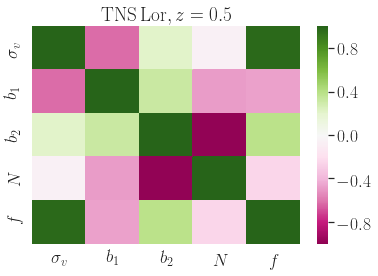

In [24]:
import pandas as pd
import seaborn as sns; sns.set()
sns.set(font_scale=1.6)

fig = plt.figure(figsize=(6,4))
df = pd.DataFrame(CovMat/np.sqrt(np.outer(np.diag(CovMat),np.diag(CovMat))))
df.rename(columns={0:'$\sigma_v$',1:'$b_1$',2:'$b_2$',3:'$N$',4:'$f$'}, inplace=True)
df.rename(index={0:'$\sigma_v$',1:'$b_1$',2:'$b_2$',3:'$N$',4:'$f$'}, inplace=True)
ax = sns.heatmap(df, cmap="PiYG", vmin=-1, vmax=1)

ax.set_title('$\mathrm{TNS \, Lor}, z=0.5$')
#plt.savefig('corr-mat-tns-zeq0p5.pdf', format="pdf", bbox_inches = 'tight')

plt.show()

In [25]:
df

,$\sigma_v$,$b_1$,$b_2$,$N$,$f$
$\sigma_v$,1.000000,-0.618788,0.211468,-0.060455,0.974429
$b_1$,-0.618788,1.000000,0.323727,-0.480270,-0.465335
$b_2$,0.211468,0.323727,1.000000,-0.983931,0.384652
$N$,-0.060455,-0.480270,-0.983931,1.000000,-0.245635
$f$,0.974429,-0.465335,0.384652,-0.245635,1.000000


## Add Gaussian priors on parameters.

In [26]:
Priormat = Fishermat*0.
Prior_errors = {
    'sv' : (sv_fid/100)*10,
    'b': (b_fid/100)*10, 
    #'b2': (b2_fid/100)*10, 
    'N': (abs(N_fid)/100)*10
}
for p in Prior_errors.keys():
    if p not in varyzdep: continue
    print (p, 'index', fm_index[p][0])
    Priormat[fm_index[p][0],fm_index[p][0]] = 1./Prior_errors[p]**2

Fishermat_comb = Fishermat+Priormat
CovMat_comb = np.linalg.inv(Fishermat+Priormat)
print ('combined marged',  np.sqrt(np.diag(CovMat_comb)))

print ('\nCorrelation coefficients after adding parameters priors:')
print (CovMat_comb/np.sqrt(np.outer(np.diag(CovMat_comb),np.diag(CovMat_comb))))

sv index 4
b index 1
N index 3
combined marged [2.728e-02 6.873e-03 9.413e-02 4.639e+01 3.397e-01]

Correlation coefficients after adding parameters priors:
[[ 1.    -0.717  0.661 -0.004  0.99 ]
 [-0.717  1.    -0.693 -0.08  -0.656]
 [ 0.661 -0.693  1.    -0.618  0.654]
 [-0.004 -0.08  -0.618  1.    -0.033]
 [ 0.99  -0.656  0.654 -0.033  1.   ]]


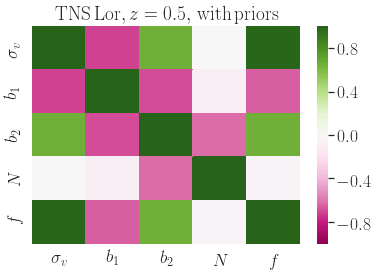

In [27]:
import pandas as pd
import seaborn as sns; sns.set()
sns.set(font_scale=1.6)

fig = plt.figure(figsize=(6,4))
df = pd.DataFrame(CovMat_comb/np.sqrt(np.outer(np.diag(CovMat_comb),np.diag(CovMat_comb))))
df.rename(columns={0:'$\sigma_v$',1:'$b_1$',2:'$b_2$',3:'$N$',4:'$f$'}, inplace=True)
df.rename(index={0:'$\sigma_v$',1:'$b_1$',2:'$b_2$',3:'$N$',4:'$f$'}, inplace=True)
ax = sns.heatmap(df, cmap="PiYG", vmin=-1, vmax=1)

ax.set_title('$\mathrm{TNS \, Lor}, z=0.5, \mathrm{\, with \, priors}$')
#plt.savefig('corr-mat-tns-zeq0p5-priors.pdf', format="pdf", bbox_inches = 'tight')

plt.show()

In [28]:
df

,$\sigma_v$,$b_1$,$b_2$,$N$,$f$
$\sigma_v$,1.000000,-0.717498,0.660734,-0.004330,0.990139
$b_1$,-0.717498,1.000000,-0.692853,-0.080113,-0.655661
$b_2$,0.660734,-0.692853,1.000000,-0.618372,0.654325
$N$,-0.004330,-0.080113,-0.618372,1.000000,-0.032547
$f$,0.990139,-0.655661,0.654325,-0.032547,1.000000


In [29]:
# Print the errors nicely
Nvar  = len(varypars)

#varyzdep = list(set(varypars)&set(zdep))
varyzdep = varypars

zdepfid = np.array([fids[p] for p in varyzdep])
print ('\nvarying zdep = \n\t', varyzdep)
if len(varyzdep)>0:
    for iz, z in enumerate(z_vals):
        zdepind = np.array([fm_index[p] for p in varyzdep])
        print ('at z =',z,': zdep fiducials = \n\t', zdepfid[:,iz])
        merrs = np.sqrt(np.diag(CovMat_comb))[zdepind[:,iz]]
        print ('at z =',z,': marged err = \n\t', merrs)
        uerrs = np.sqrt(1./np.diag(Fishermat_comb))[zdepind[:,iz]]
        print ('at z =',z,': unmarged err = \n\t', uerrs)
        print ('at z =',z,': marged % err = \n\t', merrs/np.abs(zdepfid[:,iz])*100.)
        print ('at z =',z,': unmarged % err = \n\t', uerrs/np.abs(zdepfid[:,iz])*100.)


varying zdep = 
	 ['f', 'b', 'b2', 'N', 'sv']
at z = 0.5 : zdep fiducials = 
	 [ 7.770e-01  1.498e+00  4.233e-01 -4.684e+02  9.544e+00]
at z = 0.5 : marged err = 
	 [2.728e-02 6.873e-03 9.413e-02 4.639e+01 3.397e-01]
at z = 0.5 : unmarged err = 
	 [2.524e-03 1.384e-03 1.350e-02 1.007e+01 3.109e-02]
at z = 0.5 : marged % err = 
	 [ 3.511  0.459 22.237  9.905  3.559]
at z = 0.5 : unmarged % err = 
	 [0.325 0.092 3.19  2.15  0.326]


## Draw Ellipses

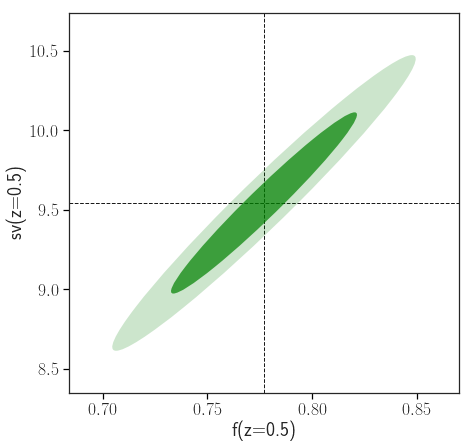

In [30]:
sns.set_style("ticks")

# Choose what to plot
zi = 0; par0 = 'f'; par1 = 'sv';

# Get the indices in the Covariance Matrix of the two parameters we want to plot
p0i = varyzdep.index(par0); index0 = zdepind[:,zi] # change this to shapeind if using shape!
p1i = varyzdep.index(par1); index1 = zdepind[:,zi] # change this to shapeind if using shape!

# Get the fiducial values for the ellipse centre
c0 = fids[par0][zi] # remove the [zi] if par0 is a shape parameter!
c1 = fids[par1][zi] # remove the [zi] if par1 is a shape parameter!

# Marginalise out everything else and make a new 2x2 Covariance Matrix
marg_all = True
if marg_all:
    covmat_2D = np.zeros((2,2))
    covmat_2D[0,0] = CovMat[index0[p0i],index0[p0i]]
    covmat_2D[1,1] = CovMat[index1[p1i],index1[p1i]]
    covmat_2D[0,1] = CovMat[index0[p0i],index1[p1i]]
    covmat_2D[1,0] = covmat_2D[0,1]
    
    
else:
    fishmat_2D = np.zeros((2,2))
    fishmat_2D[0,0] = Fishermat[index0[p0i],index0[p0i]]
    fishmat_2D[1,1] = Fishermat[index1[p1i],index1[p1i]]
    fishmat_2D[0,1] = Fishermat[index0[p0i],index1[p1i]]
    fishmat_2D[1,0] = fishmat_2D[0,1]
    covmat_2D = np.linalg.inv(fishmat_2D)
    del fishmat_2D

def get_ellipses(centre,CM_2D):
    # We will need coefficients for the ellipse depending on the number of sigma level we want
    CL_alpha = {
        1: 1.52, 
        2: 2.48,
        3: 3.44
    }

    # Get the errors
    FM_2D = np.linalg.inv(CM_2D)
    em0 = np.sqrt(CM_2D[0,0])
    eu0 = np.sqrt(1./FM_2D[0,0])
    em1 = np.sqrt(CM_2D[1,1])
    eu1 = np.sqrt(1./FM_2D[1,1])

    #print par0, eu0, em0
    #print par1, eu1, em1

    # Now calculate the ellipse parameters
    a = np.sqrt(0.5*(CM_2D[0,0]+CM_2D[1,1]) + np.sqrt(0.25*(CM_2D[0,0]-CM_2D[1,1])**2 + CM_2D[0,1]**2))
    b = np.sqrt(0.5*(CM_2D[0,0]+CM_2D[1,1]) - np.sqrt(0.25*(CM_2D[0,0]-CM_2D[1,1])**2 + CM_2D[0,1]**2))
    theta = 180./np.pi * 0.5*np.arctan(2.*CM_2D[0,1] / (CM_2D[0,0]-CM_2D[1,1])) # should be in degrees

    if CM_2D[0,0]<CM_2D[1,1]:
        width=2.*b
        height=2.*a
    else:
        width=2.*a
        height=2.*b

    # Create all the ellipses
    ellipse1 = Ellipse([centre[0],centre[1]], width*CL_alpha[1], height*CL_alpha[1], theta, 
                       linewidth=0, fill=True, zorder=2, alpha=0.7, color='green')
    ellipse2 = Ellipse([centre[0],centre[1]], width*CL_alpha[2], height*CL_alpha[2], theta, 
                       linewidth=0, fill=True, zorder=2, alpha=0.2, color='green')

    return ellipse1, ellipse2, CL_alpha[1]*em0, CL_alpha[1]*em1, CL_alpha[1]*eu0, CL_alpha[1]*eu1

# Make a test plot
ell1, ell2, errm0, errm1, erru0, erru1 = get_ellipses([c0,c1],covmat_2D)

fig, ax = plt.subplots(figsize=(7,7))

ax.axhline(c1,ls='--',c='k',lw=1); ax.axvline(c0,ls='--',c='k',lw=1) # Centre lines
#ax.axvline(c0-errm0,ls=':',c='g',lw=1); ax.axvline(c0+errm0,ls=':',c='g',lw=1) # Marginalised error lines par0
#ax.axvline(c0-erru0,ls=':',c='c',lw=1); ax.axvline(c0+erru0,ls=':',c='c',lw=1) # Marginalised error lines par0
#ax.axhline(c1-errm1,ls=':',c='g',lw=1); ax.axhline(c1+errm1,ls=':',c='g',lw=1) # Marginalised error lines par1
#ax.axhline(c1-erru1,ls=':',c='c',lw=1); ax.axhline(c1+erru1,ls=':',c='c',lw=1) # Marginalised error lines par1

ax.add_artist(ell1)
ax.add_artist(ell2)
ax.set_xlim(c0-errm0*2.1, c0+errm0*2.1)
ax.set_ylim(c1-errm1*2.1, c1+errm1*2.1)
ax.tick_params(color='black')
ax.set_facecolor('none')
#ax.axis('off')

plt.xlabel(par0+'(z='+str(z_vals[zi])+')')
plt.ylabel(par1+'(z='+str(z_vals[zi])+')')

#plt.savefig('test.png', format="png", bbox_inches = 'tight')
plt.show()

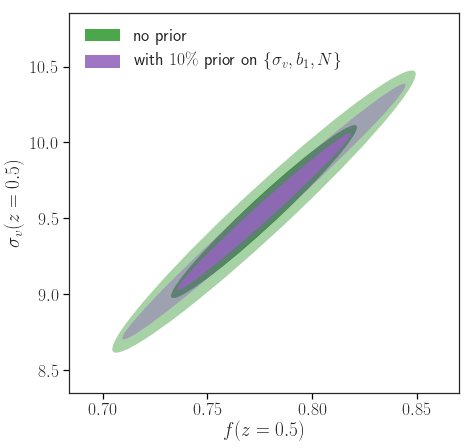

In [31]:
sns.set_style("ticks")

# Choose what to plot
zi = 0; par0 = 'f'; par1 = 'sv';

# Get the indices in the Covariance Matrix of the two parameters we want to plot
p0i = varyzdep.index(par0); index0 = zdepind[:,zi] # change this to shapeind if using shape!
p1i = varyzdep.index(par1); index1 = zdepind[:,zi] # change this to shapeind if using shape!

# Get the fiducial values for the ellipse centre
c0 = fids[par0][zi] # remove the [zi] if par0 is a shape parameter!
c1 = fids[par1][zi] # remove the [zi] if par1 is a shape parameter!

# Marginalise out everything else and make a new 2x2 Covariance Matrix
marg_all = True
if marg_all:
    covmat_2D_comb = np.zeros((2,2))
    covmat_2D_comb[0,0] = CovMat_comb[index0[p0i],index0[p0i]]
    covmat_2D_comb[1,1] = CovMat_comb[index1[p1i],index1[p1i]]
    covmat_2D_comb[0,1] = CovMat_comb[index0[p0i],index1[p1i]]
    covmat_2D_comb[1,0] = covmat_2D_comb[0,1]
    
else:
    fishmat_2D_comb = np.zeros((2,2))
    fishmat_2D_comb[0,0] = Fishermat_comb[index0[p0i],index0[p0i]]
    fishmat_2D_comb[1,1] = Fishermat_comb[index1[p1i],index1[p1i]]
    fishmat_2D_comb[0,1] = Fishermat_comb[index0[p0i],index1[p1i]]
    fishmat_2D_comb[1,0] = fishmat_2D_comb[0,1]
    covmat_2D_comb = np.linalg.inv(fishmat_2D_comb)
    del fishmat_2D_comb

def get_ellipses(centre,CM_2D,sty={'w':0,'s':'-','f':True,'a':0.7,'c':'green'}):
    # We will need coefficients for the ellipse depending on the number of sigma level we want
    CL_alpha = {
        1: 1.52, 
        2: 2.48,
        3: 3.44
    }

    # Get the errors
    FM_2D = np.linalg.inv(CM_2D)
    em0 = np.sqrt(CM_2D[0,0])
    eu0 = np.sqrt(1./FM_2D[0,0])
    em1 = np.sqrt(CM_2D[1,1])
    eu1 = np.sqrt(1./FM_2D[1,1])

    #print par0, eu0, em0
    #print par1, eu1, em1

    # Now calculate the ellipse parameters
    a = np.sqrt(0.5*(CM_2D[0,0]+CM_2D[1,1]) + np.sqrt(0.25*(CM_2D[0,0]-CM_2D[1,1])**2 + CM_2D[0,1]**2))
    b = np.sqrt(0.5*(CM_2D[0,0]+CM_2D[1,1]) - np.sqrt(0.25*(CM_2D[0,0]-CM_2D[1,1])**2 + CM_2D[0,1]**2))
    theta = 180./np.pi * 0.5*np.arctan(2.*CM_2D[0,1] / (CM_2D[0,0]-CM_2D[1,1])) # should be in degrees

    if CM_2D[0,0]<CM_2D[1,1]:
        width=2.*b
        height=2.*a
    else:
        width=2.*a
        height=2.*b

    # Create all the ellipses   
    ellipse1 = Ellipse([centre[0],centre[1]], width*CL_alpha[1], height*CL_alpha[1], theta, 
                       linewidth=sty['w'], ls = sty['s'], fill=sty['f'], zorder=2, alpha=sty['a'], color=sty['c'])
    leg1 = ellipse1.set(clip_box=ax.bbox, alpha=sty['a'], facecolor=sty['c'])
    ellipse2 = Ellipse([centre[0],centre[1]], width*CL_alpha[2], height*CL_alpha[2], theta, 
                       linewidth=sty['w'], ls = sty['s'], fill=sty['f'], zorder=2, alpha=sty['a']/2, color=sty['c'])
    leg2 = ellipse2.set(clip_box=ax.bbox, alpha=sty['a']/2, facecolor=sty['c'])

    return ellipse1, ellipse2, CL_alpha[1]*em0, CL_alpha[1]*em1, CL_alpha[1]*eu0, CL_alpha[1]*eu1, leg1, leg2

# Make a test plot
ell1, ell2, errm0, errm1, erru0, erru1, leg1, leg2 = get_ellipses([c0,c1],covmat_2D) #without priors
ell1_p, ell2_p, errm0_p, errm1_p, erru0_p, erru1_p, leg1_p, leg2_p = get_ellipses([c0,c1],covmat_2D_comb,
                                                    {'w':0,'s':'-','f':True,'a':0.9,'c':'tab:purple'}) #with priors
ells = [ell1,ell2,ell1_p,ell2_p]
fig, ax = plt.subplots(figsize=(7,7))

#ax.axhline(c1,ls='--',c='k',lw=1); ax.axvline(c0,ls='--',c='k',lw=1) # Centre lines

ax.add_artist(ell1)
ax.add_artist(ell2)
ax.add_artist(ell1_p)
ax.add_artist(ell2_p)
ax.set_xlim(c0-errm0*2.1, c0+errm0*2.1)
ax.set_ylim(c1-errm1*2.1, c1+errm1*2.3)
ax.tick_params(color='black')
ax.set_facecolor('none')
#ax.axis('off')

#plt.xlabel(par0+'(z='+str(z_vals[zi])+')')
#plt.ylabel(par1+'(z='+str(z_vals[zi])+')')
plt.xlabel('$f(z=0.5)$')
plt.ylabel('$\sigma_v(z=0.5)$')

ax.legend([ell1,ell1_p], [r'no prior',r'with $10\%$ prior on $\{\sigma_v,b_1,N\}$'],loc='upper left',frameon=False)

#plt.savefig('contour.pdf', format="pdf", bbox_inches = 'tight')

plt.show()

##### Alkistis & Dida, 2019